In [32]:
import pandas as pd
from database.BuildingRepository import BuildingRepository
from pandas.api.types import is_numeric_dtype
from datetime import datetime, timedelta

building_repo = BuildingRepository()
df = pd.DataFrame(building_repo.get_power_historic_interval(datetime.now()-timedelta(days=31), datetime.now()- timedelta(days=1)))
df = df.drop("_id", axis=1)
df['datetime'] = pd.to_datetime(df['datetime'])

df.set_index("datetime", inplace=True)
df = df.resample('15T').mean()
df["datetime"] = df.index

df['totalpower'] = pd.to_numeric(df['totalpower'], errors='coerce')
df['Month'] = df['datetime'].dt.month
df['Day'] = df['datetime'].dt.day
df['Hour'] = df['datetime'].dt.hour
df['Weekday'] = df['datetime'].dt.weekday

df.rename(columns={'totalpower': 'Consumption'}, inplace=True)
df.drop(['datetime', 'totalgeneration'], axis=1, inplace=True)

df = df.dropna()
df['Consumption-1'] = df['Consumption'].shift(1)
df.loc[df['Day'] != df['Day'].shift(1), 'Consumption-1'] = 0
df['Consumption-2'] = df['Consumption'].shift(2)
df.loc[df['Day'] != df['Day'].shift(2), 'Consumption-2'] = 0
#df = df[['Month', 'Day', 'Hour', 'Consumption-1', 'Consumption-2', 'Consumption']]
df = df[['Month', 'Day', 'Hour', 'Weekday', 'Consumption-1', 'Consumption-2', 'Consumption']]
df

,Month,Day,Hour,Weekday,Consumption-1,Consumption-2,Consumption
datetime,,,,,,,
2023-10-14 15:00:00,10,14,15,5,0.000000,0.000000,1344.275720
2023-10-14 15:15:00,10,14,15,5,1344.275720,0.000000,1357.291667
2023-10-14 15:30:00,10,14,15,5,1357.291667,1344.275720,1362.894444
2023-10-14 15:45:00,10,14,15,5,1362.894444,1357.291667,1366.525000
2023-10-14 16:00:00,10,14,16,5,1366.525000,1362.894444,1358.997222
...,...,...,...,...,...,...,...
2023-11-13 14:00:00,11,13,14,0,2416.663317,2322.697206,2443.336165
2023-11-13 14:15:00,11,13,14,0,2443.336165,2416.663317,2528.923317
2023-11-13 14:30:00,11,13,14,0,2528.923317,2443.336165,2608.029428


In [33]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, concatenate
import matplotlib.pyplot as plt

# Assume 'df' is your DataFrame with the described columns
# Make sure the timestamp column is in datetime format

# Extract the relevant columns
time_features = df[['Month', 'Day', 'Hour', 'Weekday']].values
consumption_data = df[['Consumption']].values

# Normalize the data between 0 and 1
scaler_time = MinMaxScaler(feature_range=(0, 1))
scaler_consumption = MinMaxScaler(feature_range=(0, 1))

scaled_time_features = scaler_time.fit_transform(time_features)
scaled_consumption_data = scaler_consumption.fit_transform(consumption_data)

In [34]:
scaled_consumption_data

array([[0.06231101],
       [0.0660969 ],
       [0.06772656],
       ...,
       [0.42989415],
       [0.4535795 ],
       [0.489148  ]])

In [35]:
# Function to create input sequences and their corresponding labels
def create_sequences(data_time, data_consumption, seq_length):
    sequences_time = []
    sequences_consumption = []
    labels = []

    for i in range(len(data_time) - seq_length - 24):  # Adjusted for predicting the next 24 hours
        seq_time = data_time[i:i+seq_length]
        seq_consumption = data_consumption[i:i+seq_length]
        label = data_consumption[i+seq_length:i+seq_length+24]  # Adjusted for predicting the next 24 hours

        sequences_time.append(seq_time)
        sequences_consumption.append(seq_consumption)
        labels.append(label)

    return np.array(sequences_time), np.array(sequences_consumption), np.array(labels)

# Define sequence length (number of time steps to look back)
sequence_length = 40  # You might need to adjust this based on the characteristics of your data

# Create sequences and labels
X_time, X_consumption, y = create_sequences(scaled_time_features, scaled_consumption_data, sequence_length)

In [36]:
# Build the LSTM model
input_time = Input(shape=(X_time.shape[1], X_time.shape[2]), name='input_time')
input_consumption = Input(shape=(X_consumption.shape[1], X_consumption.shape[2]), name='input_consumption')

lstm_time = LSTM(units=50, return_sequences=True)(input_time)
lstm_time = LSTM(units=50)(lstm_time)

lstm_consumption = LSTM(units=50, return_sequences=True)(input_consumption)
lstm_consumption = LSTM(units=50)(lstm_consumption)

concatenated = concatenate([lstm_time, lstm_consumption])

output = Dense(units=24, name='output')(concatenated)  # Adjusted for predicting the next 24 hours

model = Model(inputs=[input_time, input_consumption], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit([X_time, X_consumption], y, epochs=50, batch_size=32)

Epoch 1/50
71/71 [==============================] - 7s 32ms/step - loss: 0.0191
Epoch 2/50
71/71 [==============================] - 3s 36ms/step - loss: 0.0074
Epoch 3/50
71/71 [==============================] - 2s 33ms/step - loss: 0.0054
Epoch 4/50
71/71 [==============================] - 2s 33ms/step - loss: 0.0049
Epoch 5/50
71/71 [==============================] - 2s 34ms/step - loss: 0.0046
Epoch 6/50
71/71 [==============================] - 2s 33ms/step - loss: 0.0044
Epoch 7/50
71/71 [==============================] - 2s 34ms/step - loss: 0.0046
Epoch 8/50
71/71 [==============================] - 3s 36ms/step - loss: 0.0042
Epoch 9/50
71/71 [==============================] - 2s 34ms/step - loss: 0.0041
Epoch 10/50
71/71 [==============================] - 2s 34ms/step - loss: 0.0040
Epoch 11/50
71/71 [==============================] - 2s 34ms/step - loss: 0.0039
Epoch 12/50
71/71 [==============================] - 3s 36ms/step - loss: 0.0039
Epoch 13/50
71/71 [==================

In [37]:
df

,Month,Day,Hour,Weekday,Consumption-1,Consumption-2,Consumption
datetime,,,,,,,
2023-10-14 15:00:00,10,14,15,5,0.000000,0.000000,1344.275720
2023-10-14 15:15:00,10,14,15,5,1344.275720,0.000000,1357.291667
2023-10-14 15:30:00,10,14,15,5,1357.291667,1344.275720,1362.894444
2023-10-14 15:45:00,10,14,15,5,1362.894444,1357.291667,1366.525000
2023-10-14 16:00:00,10,14,16,5,1366.525000,1362.894444,1358.997222
...,...,...,...,...,...,...,...
2023-11-13 14:00:00,11,13,14,0,2416.663317,2322.697206,2443.336165
2023-11-13 14:15:00,11,13,14,0,2443.336165,2416.663317,2528.923317
2023-11-13 14:30:00,11,13,14,0,2528.923317,2443.336165,2608.029428


1/1 [==============================] - 2s 2s/step


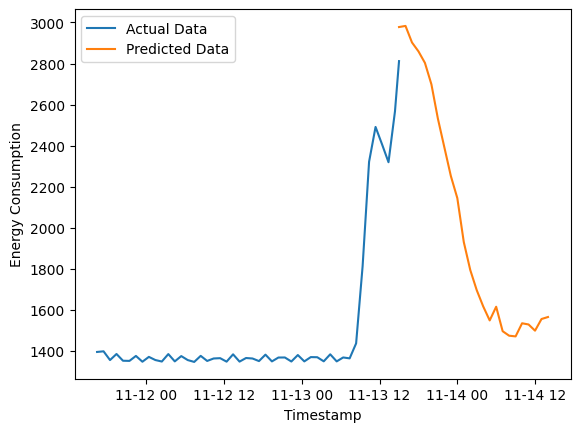

In [38]:
# Generate predictions
last_sequence_time = scaled_time_features[-sequence_length:]
last_sequence_consumption = scaled_consumption_data[-sequence_length:]
last_sequence_time = last_sequence_time.reshape((1, sequence_length, 4))  # Assuming 4 time-related features
last_sequence_consumption = last_sequence_consumption.reshape((1, sequence_length, 1))  # Assuming 3 consumption features

predicted_data = model.predict([last_sequence_time, last_sequence_consumption])

# Invert the scaling to get predictions in the original scale
predicted_data = scaler_consumption.inverse_transform(predicted_data.reshape((24, 1)))

df['datetime'] = df.index
df = df.resample('1H').mean()
# Plot the results
plt.plot(df['datetime'][-48:], df[['Consumption']][-48:], label='Actual Data')
plt.plot(pd.date_range(start=df['datetime'].iloc[-1], periods=24, freq='H'), predicted_data, label='Predicted Data')
plt.xlabel('Timestamp')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()

In [40]:
model.save('saved_model/your_model_path.h5')
import joblib

# Assuming you have a scaler object named 'scaler'
joblib.dump(scaler_time, 'saved_model/scaler_time.pkl')
joblib.dump(scaler_consumption, 'saved_model/scaler_consumption.pkl')

scaler_time = joblib.load('saved_model/scaler_time.pkl')
scaler_consumption = joblib.load('saved_model/scaler_consumption.pkl')

/home/pardalito/miniconda3/envs/tiocps/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [49]:
import numpy as np
from tensorflow.keras.models import load_model

def load_and_predict(model_path, time_features, consumption_data, sequence_length):
    # Load the model
    model = load_model(model_path)

    scaled_time_features = scaler_time.fit_transform(time_features)
    scaled_consumption_data = scaler_consumption.fit_transform(consumption_data)
    
    last_sequence_time = scaled_time_features[-sequence_length:]
    last_sequence_consumption = scaled_consumption_data[-sequence_length:]
    last_sequence_time = last_sequence_time.reshape((1, sequence_length, 4))  # Assuming 4 time-related features
    last_sequence_consumption = last_sequence_consumption.reshape((1, sequence_length, 1))  # Assuming 3 consumption features
    
    predicted_data = model.predict([last_sequence_time, last_sequence_consumption])
    
    # Invert the scaling to get predictions in the original scale
    predicted_data = scaler_consumption.inverse_transform(predicted_data.reshape((24, 1)))

    return predicted_data


In [55]:
today = datetime.now().date()
midnight_today = datetime(today.year, today.month, today.day, 12, 0, 0)

X = pd.DataFrame(building_repo.get_power_historic_interval(midnight_today-timedelta(days=1), midnight_today))
X = X.drop("_id", axis=1)
X['datetime'] = pd.to_datetime(X['datetime'])

X.set_index("datetime", inplace=True)
X = X.resample('15T').mean()
X["datetime"] = X.index

X['totalpower'] = pd.to_numeric(X['totalpower'], errors='coerce')
X['Month'] = X['datetime'].dt.month
X['Day'] = X['datetime'].dt.day
X['Hour'] = X['datetime'].dt.hour
X['Weekday'] = X['datetime'].dt.weekday

X.rename(columns={'totalpower': 'Consumption'}, inplace=True)
X.drop(['totalgeneration'], axis=1, inplace=True)

X = X.dropna()
X['Consumption-1'] = X['Consumption'].shift(1)
X.loc[X['Day'] != X['Day'].shift(1), 'Consumption-1'] = 0
X['Consumption-2'] = X['Consumption'].shift(2)
X.loc[X['Day'] != X['Day'].shift(2), 'Consumption-2'] = 0
#X = X[['Month', 'Day', 'Hour', 'Weekday', 'Consumption-1', 'Consumption-2', 'Consumption']]
X = X[['Month', 'Day', 'Hour', 'Weekday', 'Consumption', 'datetime']]
X

,Month,Day,Hour,Weekday,Consumption,datetime
datetime,,,,,,
2023-11-13 12:00:00,11,13,12,0,3025.532383,2023-11-13 12:00:00
2023-11-13 12:15:00,11,13,12,0,2677.613872,2023-11-13 12:15:00
2023-11-13 12:30:00,11,13,12,0,1976.849983,2023-11-13 12:30:00
2023-11-13 12:45:00,11,13,12,0,1947.174983,2023-11-13 12:45:00
2023-11-13 13:00:00,11,13,13,0,2226.460539,2023-11-13 13:00:00
...,...,...,...,...,...,...
2023-11-14 10:45:00,11,14,10,1,2358.028888,2023-11-14 10:45:00
2023-11-14 11:00:00,11,14,11,1,2383.524972,2023-11-14 11:00:00
2023-11-14 11:15:00,11,14,11,1,2632.185733,2023-11-14 11:15:00


In [56]:
# Example usage
model_path = 'saved_model/your_model_path.h5'
time_features_to_predict = X[['Month', 'Day', 'Hour', 'Weekday']].values
consumption_data_to_predict = X[['Consumption']].values

predictions = load_and_predict(model_path, time_features_to_predict, consumption_data_to_predict, sequence_length=40)

# 'predictions' now contains the predicted consumption values for the next 24 hours
print(predictions)


1/1 [==============================] - 1s 895ms/step
[[2295.8467]
 [2082.4856]
 [1878.9012]
 [1781.3691]
 [1640.4414]
 [1614.244 ]
 [1468.9714]
 [1409.2643]
 [1470.3701]
 [1403.4827]
 [1425.9972]
 [1447.8855]
 [1378.9408]
 [1397.342 ]
 [1427.41  ]
 [1458.2335]
 [1461.0137]
 [1464.9922]
 [1468.8202]
 [1457.8385]
 [1415.759 ]
 [1378.0934]
 [1401.019 ]
 [1361.2572]]


In [57]:
y = pd.DataFrame(building_repo.get_power_historic_interval(midnight_today, datetime.now()))
y = y.drop("_id", axis=1)
y['datetime'] = pd.to_datetime(y['datetime'])

y.set_index("datetime", inplace=True)
y = y.resample('15T').mean()
y["datetime"] = y.index

y['totalpower'] = pd.to_numeric(y['totalpower'], errors='coerce')
y.rename(columns={'totalpower': 'Consumption'}, inplace=True)
y

,Consumption,totalgeneration,datetime
datetime,,,
2023-11-14 12:00:00,2542.526667,525.577778,2023-11-14 12:00:00
2023-11-14 12:15:00,2284.467221,346.580556,2023-11-14 12:15:00
2023-11-14 12:30:00,2261.796631,790.597222,2023-11-14 12:30:00
2023-11-14 12:45:00,1823.221667,493.256944,2023-11-14 12:45:00
2023-11-14 13:00:00,2439.558889,338.856944,2023-11-14 13:00:00
2023-11-14 13:15:00,2549.156667,291.756944,2023-11-14 13:15:00
2023-11-14 13:30:00,2921.268331,310.334722,2023-11-14 13:30:00
2023-11-14 13:45:00,2929.556294,302.413889,2023-11-14 13:45:00
2023-11-14 14:00:00,2901.927216,452.411111,2023-11-14 14:00:00


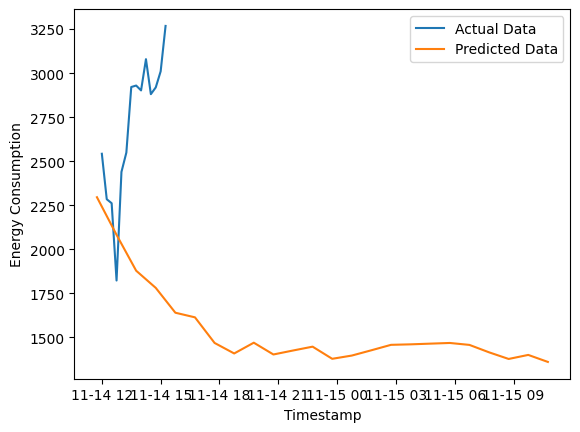

In [58]:
plt.plot(y['datetime'], y['Consumption'], label='Actual Data')
plt.plot(pd.date_range(start=X['datetime'].iloc[-1], periods=24, freq='H'), predictions, label='Predicted Data')
plt.xlabel('Timestamp')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()
